In [ ]:
import torch
from flow_matching.supervised.alphas_betas import LinearAlpha, LinearBeta
from flow_matching.supervised.prob_paths import GaussianConditionalProbabilityPath

from flow_matching.whar.sampler import WHARSampler
from flow_matching.whar.unet import WHARUnet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sampler = WHARSampler()

Creating config hash...
Checking download...
Download exists.
Checking sessions...
Sessions exist.
Validating common format...
[########################################] | 100% Completed | 741.38 ms
Common format validated.
Checking windowing...
Loading config hash...
Windowing exists.
subject_ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
activity_ids: [0 1 2 3 4 5]
train: 7046 | val: 782 | test: 1671
Postprocessing...


Loading windows: 100%|██████████| 9499/9499 [00:07<00:00, 1313.31it/s]


Getting normalization parameters...
Loading config hash...
Creating normalization parameters hash...
Loading normalization parameters hash...


Loading samples: 100%|██████████| 9499/9499 [00:01<00:00, 7201.02it/s]


In [ ]:
shape = sampler.get_shape()
print(shape)
num_classes = len(sampler.dataset.get_class_weights(sampler.train_loader).keys())
print(num_classes)

path = GaussianConditionalProbabilityPath(
    p_data=sampler,
    p_simple_shape=shape,
    alpha=LinearAlpha(),
    beta=LinearBeta(),
).to(device)

unet = WHARUnet(
    in_channels=shape[0],
    channels=[16, 32, 64],
    num_blocks=2,
    emb_dim=16,
    num_classes=num_classes,
).to(device)

unet.load_state_dict(torch.load("unet.pt"))

[9, 5, 64]
6


<All keys matched successfully>

100%|██████████| 99/99 [00:00<00:00, 196.68it/s]


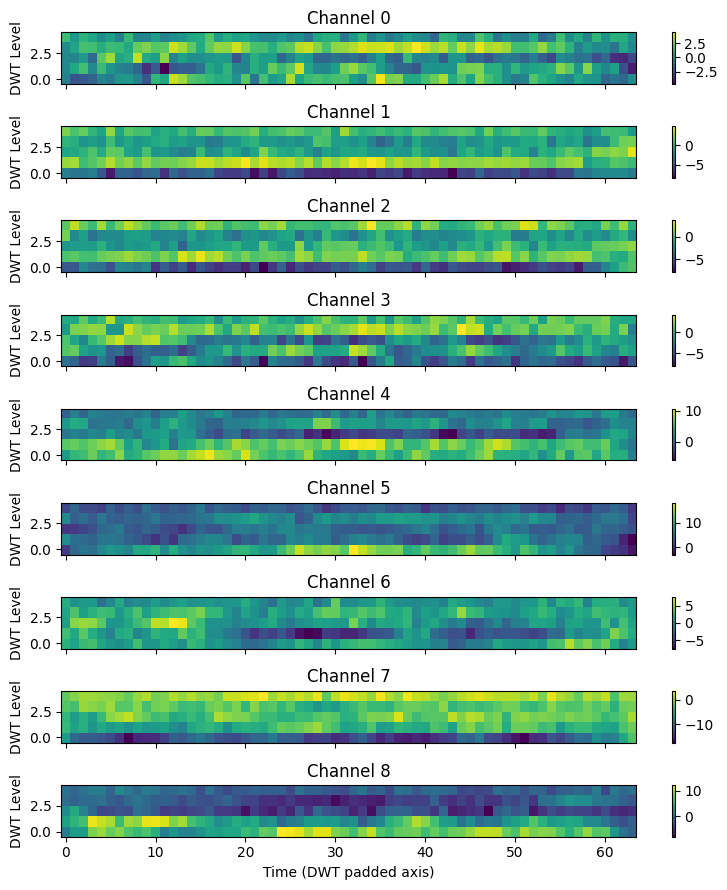

(128, 9)


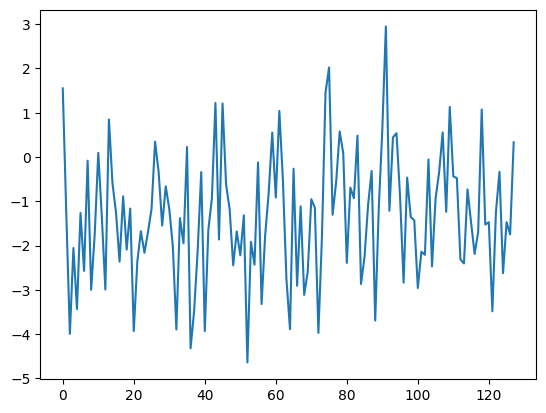

In [16]:
# Play with these!
from matplotlib import pyplot as plt
from flow_matching.supervised.odes_sdes import CFGVectorFieldODE
from flow_matching.supervised.simulators import EulerSimulator
from whar_datasets.core.features.wavelet_transform import (
    plot_dwt_grid,
    dtw_grid_to_signal,
)


activity_id = 2
num_timesteps = 100
guidance_scale = 5.0

# Sample initial conditions
y = torch.tensor([activity_id], dtype=torch.int64).repeat_interleave(1).to(device)
num_samples = y.shape[0]
x0, _ = path.p_simple.sample(1)  # (num_samples, 1, 32, 32)

ode = CFGVectorFieldODE(unet, null_class=num_classes, guidance_scale=guidance_scale)
simulator = EulerSimulator(ode)

# Simulate
ts = (
    torch.linspace(0, 1, num_timesteps)
    .view(1, -1, 1, 1, 1)
    .expand(num_samples, -1, 1, 1, 1)
    .to(device)
)
x1 = simulator.simulate(x0, ts, y=y)
grid = x1[0].to("cpu").numpy()
plot_dwt_grid(grid)

lengths = sampler.get_lengths()
signal_recon = dtw_grid_to_signal(grid, lengths)
print(signal_recon.shape)
plt.plot(signal_recon[:, 1])
plt.show()